<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans

In [19]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


## Import section


In [0]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

# Classifiers
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import model_selection
from sklearn import metrics

## preprocessing

In [0]:
def Replace(i):
    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

def preprocessing_steps(X_data, Y_data):
    # remove strings from data
    X_data = X_data.applymap(func=Replace)

    # set 0.0 as NaN
    X_data = X_data.replace(0, np.nan)

    # set Inf as NaN
    pd.options.mode.use_inf_as_na = True # inf waardes zien als nan
    # X_data.replace([np.inf, -np.inf], np.nan)

    # remove features with less than 60% values
    X_data = X_data.dropna(thresh=round(len(X_data)*0.8), axis='columns')

    # remove sample with less than 60% values
    # join features and labels
    XY_data = X_data.join(Y_data)
    # remove samples with not enough values
    XY_data = XY_data.dropna(thresh=round(XY_data.shape[1]*0.6))

    # remove samples without a label
    XY_data['label'].replace(np.nan, '', inplace=True)
    XY_data = XY_data[XY_data['label'].astype(bool)]
    
    # Add missing value's 
    X_data = X_data.fillna(0)

    # normalisation of values
    #X_data = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(X_data), columns=X_data.index, index=X_data.columns)
    X_data = pd.DataFrame(QuantileTransformer(output_distribution='uniform').fit_transform(X_data), columns=X_data.columns, index=X_data.index) # output_distribution='normal'

    return X_data, Y_data

## Feature selection and extraction

In [0]:
def feature_steps(X_data, Y_data):
    # Classifier to visualize feature selection
    impo_clf = ExtraTreesClassifier(n_estimators=50)
    impo_clf = impo_clf.fit(X_data, Y_data)

    importances = impo_clf.feature_importances_
    std = np.std([impo_clf.feature_importances_ for tree in impo_clf.estimators_], 
                 axis=0)
    indices = np.argsort(importances)[::-1]


    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_data.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_data.shape[1]), indices)
    plt.xlim([-1, X_data.shape[1]])
    plt.show()

    # Feature selection
    model = SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50))
    X_data = model.fit_transform(X_data, Y_data)
    print(model.threshold_)

    

    return X_data, Y_data

## Run Pipeline

run all predefined steps

The number of samples: 167
The number of columns: 725


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


             label
ID                
TCGA-02-0064   GBM
TCGA-02-0068   GBM
TCGA-02-0069   GBM
TCGA-02-0070   GBM
TCGA-02-0075   GBM
...            ...
TCGA-HT-8018   LGG
TCGA-HT-8111   LGG
TCGA-HT-8114   LGG
TCGA-HT-8563   LGG
TCGA-HT-A61A   LGG

[150 rows x 1 columns]


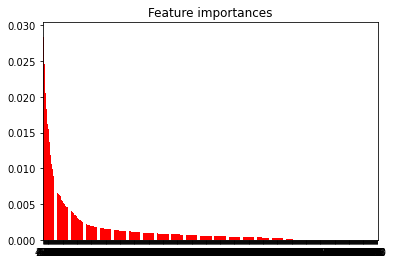

0.001445086705202312
(150, 145)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [59]:
# Data loading functions.
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data = pd.DataFrame(data)

# split labels and values
data_X = data.drop(columns=['label'])
data_Y = data[['label']]

# data split index forming
Test_split = model_selection.StratifiedKFold(n_splits=10)

i = 0 # temp

for design_index, test_index in Test_split.split(data_X, data_Y):
    if i:       # temp
      continue  # temp
    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing step
    X_design, Y_design = preprocessing_steps(X_design, Y_design)

    #X_test, Y_test = preprocessing_steps(X_test, Y_test)
    print(Y_design)


    #run feature selection and extraction
    X_design, Y_design = feature_steps(X_design, Y_design)
    print(X_design.shape)
      
    i = 1     # temp

# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')

